In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set()
%matplotlib inline

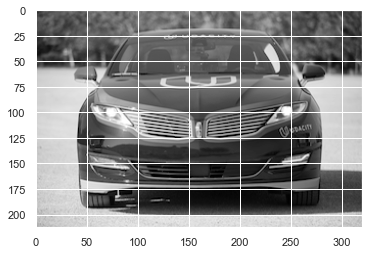

In [2]:
# load the image and convert into grayscale
bgr_image = cv2.imread('images/udacity_sdc.png')
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

# normalize, rescale entries to be in [0, 1]
gray_image = gray_image.astype('float32') / 255

# plot the image
plt.imshow(gray_image, cmap='gray')
plt.show()

In [3]:
# define and visualize the filters
filter_vals = np.array([
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, 1, 1]
])
print(filter_vals.shape)

filter1 = filter_vals
filter2 = -filter1
filter3 = filter1.T
filter4 = -filter3
filters = np.array([filter1, filter2, filter3, filter4])

(4, 4)


No handles with labels found to put in legend.


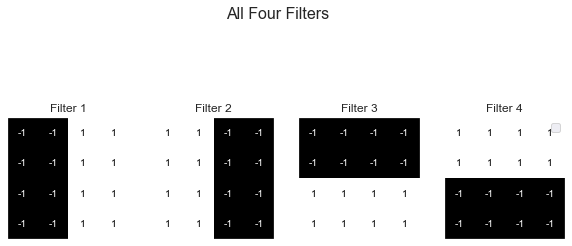

In [4]:
# visualize all four filters
fig = plt.figure(figsize=(10, 5))
fig.suptitle('All Four Filters', fontsize=16)
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i + 1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y] < 0 else 'black')
plt.legend()
plt.show()

## Define a convolutional layer

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll start by defining a:
* Convolutional layer

Initialize a single convolutional layer so that it contains all your created filters. Note that you are not training this network; you are initializing the weights in a convolutional layer so that you can visualize what happens after a forward pass through this network!


#### `__init__` and `forward`
To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the forward behavior of a network that applyies those initialized layers to an input (`x`) in the function `forward`. In PyTorch we convert all inputs into the Tensor datatype, which is similar to a list data type in Python.

Below, I define the structure of a class called `Net` that has a convolutional layer that can contain four 3x3 grayscale filters.

In [6]:
class CNN(nn.Module):
    def __init__(self, weights):
        super(CNN, self).__init__()
        # initialize the weights of the convolutional layer to be the weights of the 4 defined filters
        k_height, k_width = weights.shape[2:]
        print(k_height, k_height)
        # define the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(k_height, k_width), bias=True)
        self.conv.weight = torch.nn.Parameter(weights)

    def forward(self, x):
        # calculate the output of a convolutional layer
        # pre- and post- activation
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)

        # return both layers
        return conv_x, activated_x

weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = CNN(weight)

model

4 4


CNN(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
)

## Visualize the output of each filter


In [7]:
def viz_layer(layer, n_filter=4):
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_filter):
        ax = fig.add_subplot(1, n_filter, i + 1, xticks=[], yticks=[])
        # grab layer output
        ax.imshow(np.squeeze(layer[0, i].data.numpy()), cmap='gray')
        ax.set_title(f'Output {i + 1}')

Grayscale image: torch.Size([1, 1, 213, 320])
Convoluted Layer: torch.Size([1, 4, 210, 317])
ReLU activated layer: torch.Size([1, 4, 210, 317])


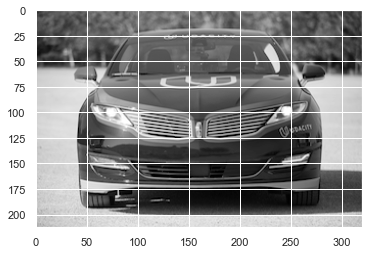

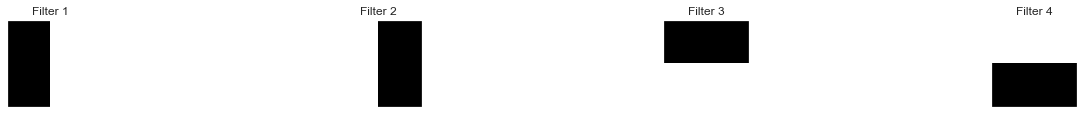

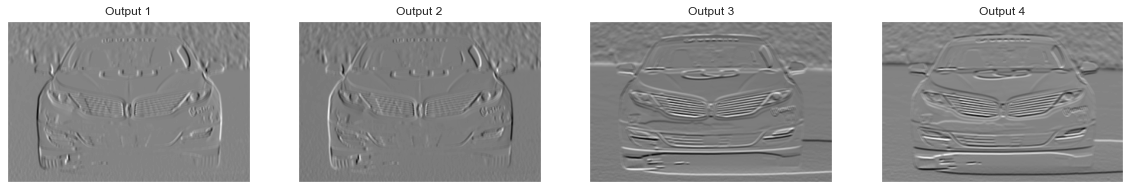

In [10]:
plt.imshow(gray_image, cmap='gray')

# visualize all filters
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title(f'Filter {i + 1}')

# convert image into an input Tensor
gray_img_tensor = torch.from_numpy(gray_image).unsqueeze(0).unsqueeze(1)
print('Grayscale image:', gray_img_tensor.shape)

# get the convolutional layer (pre and post- activation)
conv_layer, activated_layer = model(gray_img_tensor)

print('Convoluted Layer:', conv_layer.shape)
print('ReLU activated layer:', activated_layer.shape)


viz_layer(conv_layer)


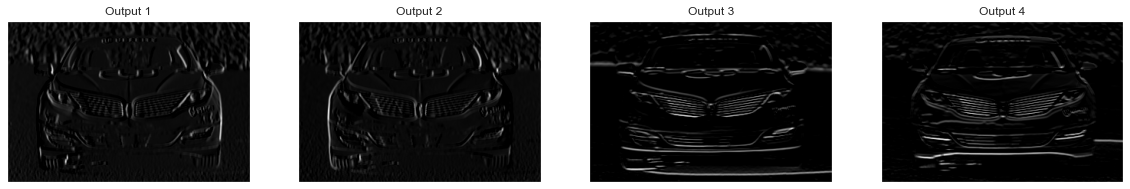

In [20]:
viz_layer(activated_layer)


# Adding Maxpooling Layer



In [14]:
class CLMaxpooling(nn.Module):
    def __init__(self, weights):
        super(CLMaxpooling, self).__init__()
        k_height, k_width = weights.shape[2:]
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        self.pool = nn.MaxPool2d(4, 4)

    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        pooled_x = self.pool(activated_x)
        return conv_x, activated_x, pooled_x

model = CLMaxpooling(weight)
model

CLMaxpooling(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
)

Convoluted shape: torch.Size([1, 4, 210, 317])
ReLU activation: torch.Size([1, 4, 210, 317])
Pooled shape: torch.Size([1, 4, 52, 79])


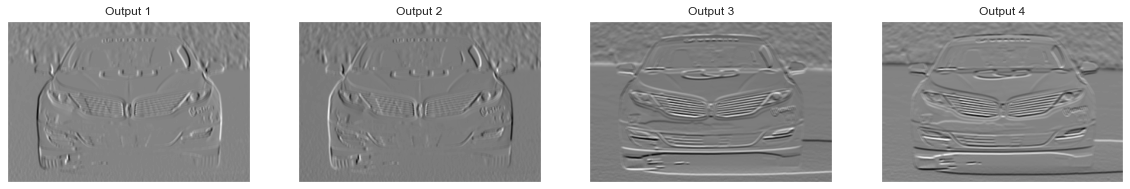

In [15]:
conv_layer, activated_layer, pooled_layer = model(gray_img_tensor)
viz_layer(conv_layer)
print('Convoluted shape:', conv_layer.shape)
print('ReLU activation:', activated_layer.shape)
print('Pooled shape:', pooled_layer.shape)


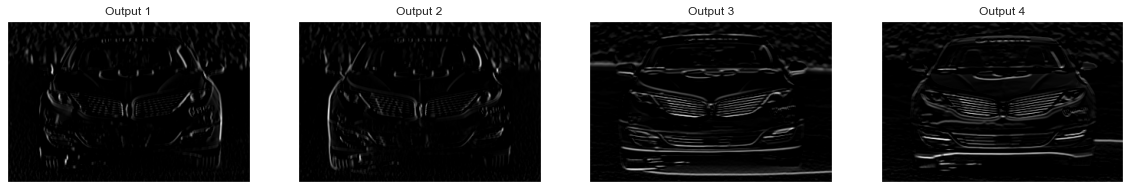

In [24]:
viz_layer(activated_layer)


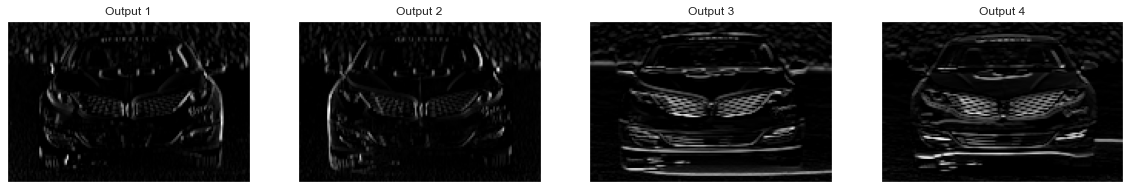

In [25]:
viz_layer(pooled_layer)
